<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/notebooks/Building_Tensorflow_Image_Input_Pipeline_using_tf_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Tensorflow Image Pipeline - tf.data

This page is part of the `Building Tensorflow Image Pipeline` series.

## Introduction

A Neural Network consists of 2 main components: The Input Data Pipeline and the Network Model.

Having that in mind, a major part in the bring up of any Neural Network, besides setting the model itself, is the setting of an efficient input data pipeline.


The costruction of input data pipeline is an Extract, Transform, Load (ETL) task, so it starts with the extraction of data stored in memory or in files(s), continues with transforming it, such that it will have an efficient data format, and then loading it to the model.

In tensorflow, the data should be extracted and arranged as a tf.data.Dataset object, and then pass through a list of transformations such as decoding batching, normalizing, resizing, shuffling, augmentating, and so forth.

This series of post presents a variety of imagedata pipeline preparation approches, all aim to provide efficient, multiprocessing capeable, yet simple processing forms. All are alike, in the sense that the output is a tf.data.Dataset object.

All posts of this series demonstrate image classification using a common source data and a common model. So, notebooks are almost identical except the input pipeline section.


The source data is `Rock Paper Scissors dataset`, listed in TensorFlow Datasets catalog. The dataset was produced by Lawrance Moroney, million thanks for him on that.

Note that these posts do not aim to demonstrate top-notch classification examples but only to present various input pipeline construction approaches. Accordingly, the network optimal are simple and not optimized.


In the following we will go step by step through a data classification code, demonstrating dataset creation using the tf.keras.preprocessing.image module.

Code components are:

1. **Import Packages**

2. **Download the data**

3. **Create the dataset** - (Extract and Transform)

4. **Configure the dataset for performance** - (Transform)

5. **Set the model**

6. **Compile the Model**

7. **Train**

8. **Display Model Summary** 

9. **Visualize Training Results***

10. **Run Inference**


...Here we go...!



## 1. Import Packages

In [118]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers

## 2. Download the data

***Rock Paper Scissors***
We will use the `Rock Paper Scissors` dataset, listed in [TensorFlow Datasets catalog](https://www.tensorflow.org/datasets/catalog/overview). The dataset was produced by [Lawrance Moroney](https://laurencemoroney.com/datasets.html), million thanks for him on that.

***Downloaded Data Format***

Here we download the dataset, which is packed as a .zip file. 


In [119]:
import pathlib
dataset_name = 'rps'
dataset_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip'
dataset_file = tf.keras.utils.get_file(origin=dataset_url, fname=dataset_name+'.zip', extract=True)

dataset_file point on downloaded file:

In [120]:
print(dataset_file)

/root/.keras/datasets/rps.zip


The downloaded zip file file was extracted , due to the `extract=True` attribute.

Let's examine the zip file and the extracted directory: 

In [121]:
import os
dataset_dir = pathlib.Path(os.path.dirname(os.path.abspath(dataset_file)))
!ls $dataset_dir

rps  rps-test-set  rps_test.zip  rps.zip


#### Each dataset subdirectory to a data class: paper  rock  scissors. Here's the subdirectory list:


In [122]:
subdir_names = [f for f in os.listdir(os.path.join(dataset_dir, dataset_name))]
print(subdir_names)

['scissors', 'paper', 'rock']


The zip file downloaded so far holds the `training` data. 

The dataset's author composed another zip file which holds the `test` data. 

Next download it:

In [123]:
dataset_test_name = 'rps_test'
dataset_test_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip'
dataset_test_file = tf.keras.utils.get_file(origin=dataset_test_url, fname=dataset_test_name+'.zip', extract=True)

In [124]:
!cp -r /root/.keras/datasets/rps-test-set/* /root/.keras/datasets/rps

The `train` and `test` datasection are split 80-20. That is fine. but for methodical reasons, The straight forward way to do is to take them as is for training and validation respectively. Methodicaly, we will merge the 2, just to demonstrate the split capabilities of the method which follows in the next notebook cell.

Let's check how much data have we got by counting number of files in each class directory

In [125]:
from os import listdir
from os.path import isfile, join
import os

class_dir_info = {}
file_ext = 'png'

base_data_dir = os.path.join(dataset_dir, 'rps')
for subdir_name in subdir_names:
  subdir = pathlib.Path(os.path.join(base_data_dir, subdir_name))
  import os, random
  files_count = len([file for file in os.listdir(subdir) if file.endswith(file_ext)])
  class_dir_info.update({'dir': subdir})
  print('{}: {} files'.format(subdir_name, files_count))

print('total file count: {}'.format(len(list(pathlib.Path(base_data_dir).glob('*/*.{}'.format(file_ext))))))

scissors: 964 files
paper: 964 files
rock: 964 files
total file count: 2892


***Visualization*** - take a brief look at randomly selected images from each class

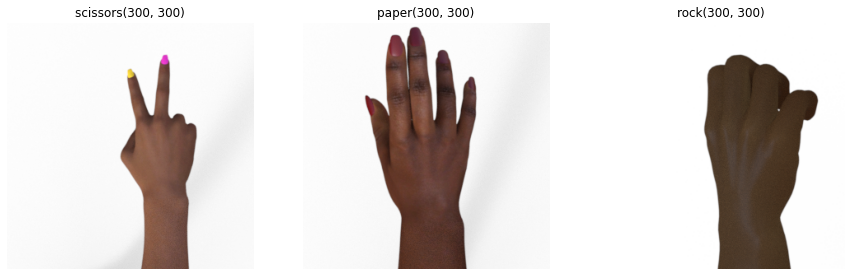

In [126]:
plt.figure(figsize=(15, 15))
for i, subdir_name in enumerate(subdir_names):
  path = pathlib.Path(os.path.join(base_data_dir, subdir_name))
  filename =random.choice(os.listdir(path))
  ax = plt.subplot(1, len(subdir_names), i + 1)
  img = PIL.Image.open(os.path.join(path, filename))
  plt.imshow(img)
  plt.axis("off")
  plt.title(subdir_names[i]+str(img.size))

## 3. Create the dataset (Extract + Transform)

Having downloaded and extracted the source data files, we we start the creation of data pipeline. 
In this post example, we use the `tf.keras.utils.image_dataset_from_directory` method.

This methods creates a dataset data. The labels are obtained automatically according to the subdirectory name, as shown next. This in addition to more data transformation goodies (detailed next).

**Important note** - the data pipeline operates in the graph mode - see details in the corresponding post (TBD). Accordingly, we first construct the graph which later be triggered with data.


In [127]:
batch_size = 32
image_height = 224
image_width = 224

Create a dataset using the list of all image files

In [128]:
base_data_dir = pathlib.Path(base_data_dir)
list_ds = tf.data.Dataset.list_files(str(base_data_dir/'*/*'), shuffle=True)

In [129]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/rps/scissors/scissors03-054.png'
b'/root/.keras/datasets/rps/paper/paper06-032.png'
b'/root/.keras/datasets/rps/paper/paper06-079.png'
b'/root/.keras/datasets/rps/paper/paper01-081.png'
b'/root/.keras/datasets/rps/rock/testrock01-04.png'


Split dataset to training and validation

In [130]:
train_size = int(len(list_ds) * 0.8)
print('train_size:',train_size)
train_ds = list_ds.take(train_size)
val_ds = list_ds.skip(train_size)

train_size: 2313


In [131]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2313
579


Extract class names from subdir names. The sorting is not essential, but provides a deterministic order.

In [132]:
class_names = np.array(sorted([item.name for item in base_data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['paper' 'rock' 'scissors']


Read image files, decode jpeg - if needed, fill dataset with images and corresponding labels.

In [133]:
def decode_img(img):
  # Convert the png to uint8 encode, 3D tensor
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [image_height, image_width])

def process_path(file_path):
  one_hot_label = tf.strings.split(file_path, os.sep)[-2] == class_names
  label = tf.argmax(one_hot_label)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


train_ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)


## 4. Configure the dataset for performance



Next we will define more essential transformations:


**Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch.

**Dataset.prefetch** overlaps data preprocessing and model execution while training. (The tf.data.AUTOTUNE parameter defines a dynamic tuning of the number of prefetched data elements. The number depends on the number of batches consumed in a single step, i.e. on parallelism extent).

**Dataset.shuffle** - The dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. (For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.)

**Dataset.batch** - Combines consecutive elements of this dataset into batches. The components of the resulting element will have an additional outer dimension, which will be batch_size (or N % batch_size for the last element if batch_size does not divide the number of input elements N evenly and drop_remainder is False). If your program depends on the batches having the same outer dimension, you should set the drop_remainder argument to True to prevent the smaller batch from being produced.(Default is drop_remainder=False)




In [134]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size, drop_remainder=False)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)


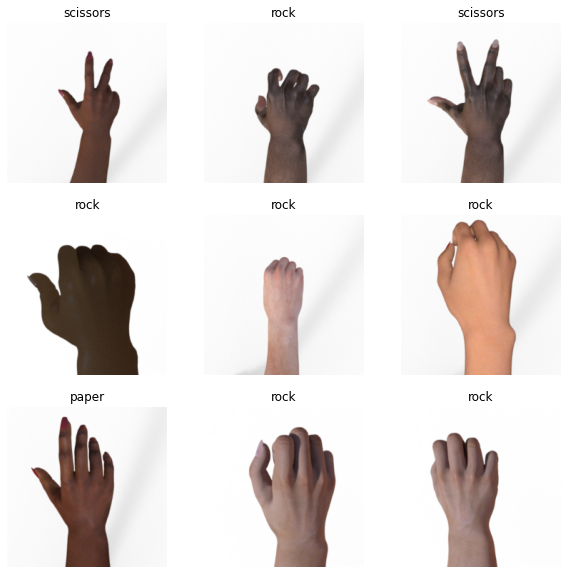

In [135]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

**Normalize the data**

Standardizes the inputs. This is often integrated within the model, but can also be set on the dataset like so:

In [136]:
normalization_layer = layers.Rescaling(1./255)

In [137]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Data Augmentation - Expand training dataset size

(Find details on Data Augmentation in a related post (TBD))

In [138]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
    layers.RandomRotation(0.9, fill_mode="nearest",),
    layers.RandomZoom(0.1),
  ]
)

**Demonstrate Augmentation Visualization**: 

Original image is at upper left, with 8 randomly augmented images. 

Note that dataset is exended to be 4 dims, as expected by the augmentation methods.


In [139]:
train_ds

<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

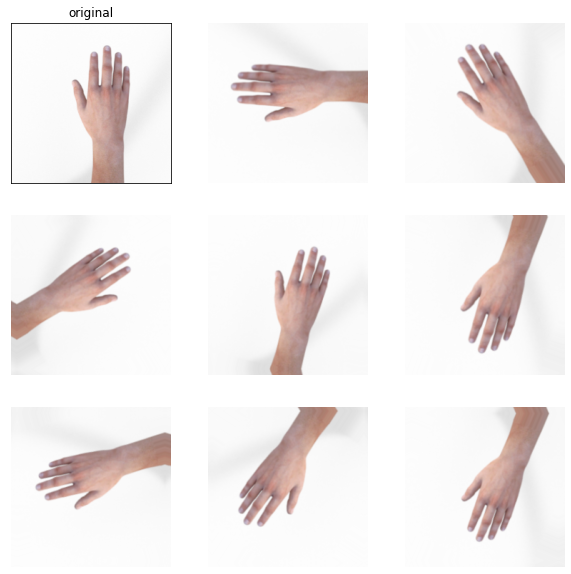

In [140]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  image = images[random.randint(0, len(images)-1)]
  ax = plt.subplot(3, 3, 1)
  ax.set_title('original')
  plt.imshow(image)
  ax.set_xticks([])
  ax.set_yticks([])

  for i in range(8):
    augmented_images = data_augmentation((tf.expand_dims(image, axis=0, name=None)))
    ax = plt.subplot(3, 3, i + 2)
    ax.imshow(augmented_images[0].numpy().astype("float32"))
    plt.axis("off")

Set Augmentation to training dataset

In [141]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

## 5. Set the model

The model consists of 7 layers:
- It begins with 5 convolution blocks, each followed by a max pooling module.

- Then, after flattening the data, convolution blocks are followed by 2 dense layers: 
 - A 128 units dense layer
 - The output layer, with 3 units according to the 3 output classes, i.e.rock, paper, scizors.


In [142]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes,  activation = 'softmax')
])

<a name='5'></a>
## 6. Compile the Model

- optimizer `adam` - a commonly used stochastic adaptive optimizer.  
- loss function `SparseCategoricalCrossentropy` - commonly used for image classification with more than 2 classes
- from_logits=True - This indicate the loss function that that the output is not normalized, i.e. there is no softmax function at the output. BTW, excluding the softmax function from the model, is considered more numerically stable. The softamx is then added by the loss function module.


In [143]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## 7. Train the model

Set an Early Stopping Callback

- Stop training when a monitored metric has stopped improving.

- Wait before stopping according `patience` value.

- Restore best waits, after stopping



In [144]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=10, 
                                verbose=1, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)

Now do the fit - 30 epochs, with early_stop_cb.

In [145]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop_cb],
)

Epoch 1/30
91/91 [==============================] - 41s 339ms/step - loss: 1.1063 - accuracy: 0.3195 - val_loss: 1.0971 - val_accuracy: 0.3921
Epoch 2/30
91/91 [==============================] - 29s 323ms/step - loss: 1.0154 - accuracy: 0.4741 - val_loss: 0.7760 - val_accuracy: 0.6131
Epoch 3/30
91/91 [==============================] - 29s 314ms/step - loss: 0.6198 - accuracy: 0.7331 - val_loss: 0.7123 - val_accuracy: 0.7064
Epoch 4/30
91/91 [==============================] - 29s 315ms/step - loss: 0.3646 - accuracy: 0.8527 - val_loss: 0.2323 - val_accuracy: 0.9499
Epoch 5/30
91/91 [==============================] - 29s 314ms/step - loss: 0.2354 - accuracy: 0.9087 - val_loss: 0.2873 - val_accuracy: 0.8653
Epoch 6/30
91/91 [==============================] - 29s 314ms/step - loss: 0.1763 - accuracy: 0.9343 - val_loss: 0.1436 - val_accuracy: 0.9430
Epoch 7/30
91/91 [==============================] - 29s 317ms/step - loss: 0.1584 - accuracy: 0.9402 - val_loss: 0.0655 - val_accuracy: 0.9862

## 8. Display model summary

In [182]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 28, 28, 128)     

## 9 Visualize training results

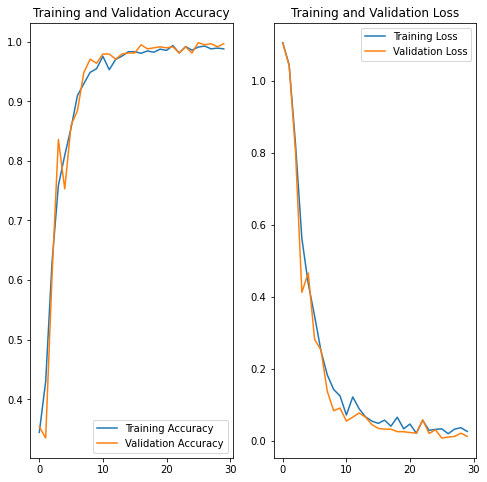

In [183]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 10. Inference

**Uppload Kaggle Auth Token**


To run the following notebook cells which use Kaggle stored dataset, a kaggle auth token (`kaggle.json` file) is needed.


If you have already a `kaggle.json` file, the code in the notebook cell which follows will upload it (click on `Choose Files`).
 
If you don't, you can generate one - click [here](https://ronen-halevy.github.io/2021/11/15/kaggle-api-settings.html) for a post on setting Kaggle API.



**Next, run inference over the trained model**

3 inference sessions follow:

The first 2 use a test dataset stored at Kaggle, and the last one runs inference over user's interactively uploaded images.

To run the first 2, you need to upload a Kaggle token, as explained next. 

If you prefer to avoid the token upload, you can skip directly to the notebook cell, titled `Run Prediction On Interactively uploaded Images`.


In [187]:
from google.colab import files

uploaded = files.upload()
  
# Move kaggle.json into ~/.kaggle:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json



**Download the test dataset from Kaggle and unzip it**

In [188]:
!kaggle datasets download -d ronenhalevy/rps-test
!unzip rps-test.zip

rps-test.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  rps-test.zip
replace rps_test/paper/papaer9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: rps_test/paper/papaer9.jpg  
  inflating: rps_test/paper/papar10.jpg  
  inflating: rps_test/paper/paper-2.jpg  
  inflating: rps_test/paper/paper3.jpg  
  inflating: rps_test/paper/paper6.jpg  
  inflating: rps_test/rock/rock.jpg  
  inflating: rps_test/rock/rock3.jpg  
  inflating: rps_test/rock/rock4.jpg  
  inflating: rps_test/rock/rock5.jpg  
  inflating: rps_test/rock/rock7.jpg  
  inflating: rps_test/rock/rock8.jpg  
  inflating: rps_test/rock/sn-rock.jpg  
  inflating: rps_test/scissors/scisors.jpg  
  inflating: rps_test/scissors/scissors3.jpg  
  inflating: rps_test/scissors/scissors4.jpg  
  inflating: rps_test/scissors/scissors5.jpg  
  inflating: rps_test/scissors/scissors6.jpg  
  inflating: rps_test/scissors/scissors7.jpg  
  inflating: rps_test/scissors/scissors8.jp

**Run Prediction over The Test Dataset**

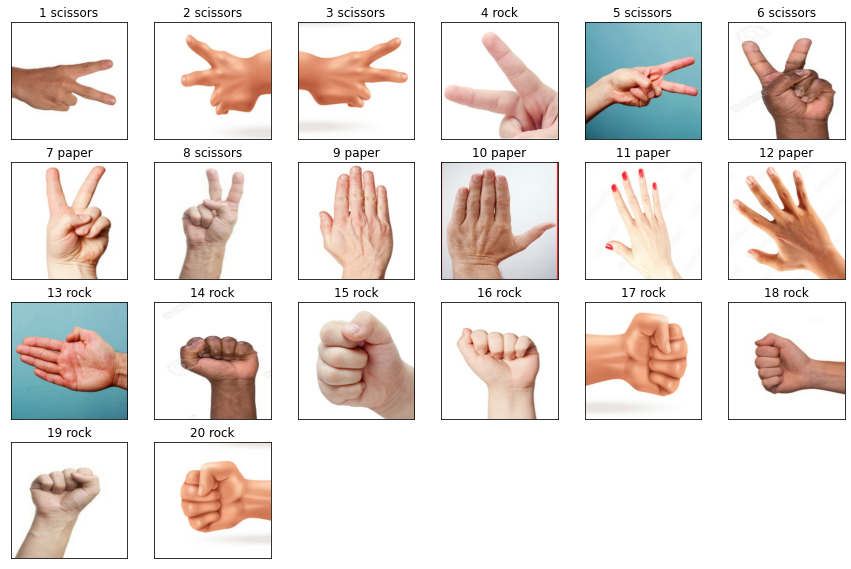

In [189]:
def do_prediction(image_folder):
    class_name=[]
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    cnt = 0
    for jdx, dir1 in enumerate(os.listdir(image_folder)):
        for idx, file in enumerate(os.listdir(os.path.join(image_folder, dir1))):
            cnt += 1
            ax = fig.add_subplot(6, 6, cnt)
            image= os.path.join(image_folder,dir1, file)
            image = tf.io.read_file(image)
            image = tf.io.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, (image_height,image_width))
            image = tf.cast(image / 255., tf.float32)
            ax.imshow(image)
            image = tf.expand_dims(image, axis=0)
            result=model.predict(tf.stack(image, axis=0))
            ax.set_title("{} {}"
              .format(cnt, class_names[np.argmax(result)])
            )          
            ax.set_xticks([])
            ax.set_yticks([])
    return
img_folder='rps_test'
do_prediction(img_folder)


**Examine prediction results**

Obviously, results with validation dataset were much better. 

There are a number of miss-classification results. A larger train dataset would probably bring better preformance, e.g. note that all papers in training dataset have gaps between fingers, and scissors images are different than those of the test dataset. 



**Find Accuracy and Loss**
 
Run `model.evaluate` over the test dataset. It calculates loss and accuracy for this data.


In [190]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  'rps_test',
  seed=123,
  image_size=(image_height, image_width),
  batch_size=3)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

results = model.evaluate(test_ds)

print(f'Test {model.metrics_names[0]}: {results[0]} / Test model.metrics_names[1]: {results[1]}')



Found 20 files belonging to 3 classes.
7/7 [==============================] - 0s 14ms/step - loss: 0.5842 - accuracy: 0.8500
Test loss: 0.5841900110244751 / Test model.metrics_names[1]: 0.8500000238418579


**Run Prediction On Interactively uploaded Images**

In next notebook cell, you can interactively upload test files(s) and execute inference

Saving rock8.jpg to rock8.jpg
Saving rock7.jpg to rock7.jpg
Saving rock5.jpg to rock5.jpg
Saving rock4.jpg to rock4.jpg
Saving rock3.jpg to rock3.jpg
Saving sn-rock.jpg to sn-rock.jpg
Saving rock.jpg to rock.jpg


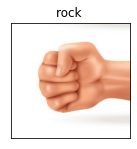

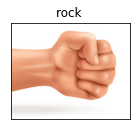

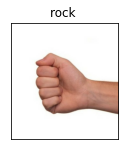

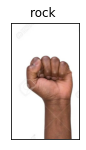

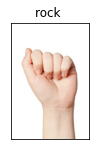

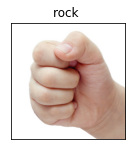

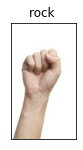

In [191]:
  uploaded = files.upload()
  cnt = 0
  for path in uploaded.keys():
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    image = tf.image.resize(img, [image_height, image_width])
    image = tf.expand_dims(image, axis=0)
    image = image / 255.0
    cnt = cnt + 1
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)

    results = model.predict(image)
    result = results[0]
    ax = fig.add_subplot(6, 6, cnt)
    ax.set_title("{} ".format(class_names[np.argmax(result)]))  
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])